# Code demo about overfitting
## Overfitting kNN
Why do we have to split the data into training sets and test sets?
Check the performance of the kNN classifier on the test and train set depending on the hyperparameter k:

In [8]:
def create_spirals(N):
    # adapted from : https://gist.github.com/45deg/e731d9e7f478de134def5668324c44c5
    
    theta = np.sqrt(np.random.rand(N))*2*np.pi # np.linspace(0,2*pi,100)

    r_a = 2*theta + np.pi
    data_a = np.array([np.cos(theta)*r_a, np.sin(theta)*r_a]).T
    x_a = data_a + np.random.randn(N,2)

    r_b = -2*theta - np.pi
    data_b = np.array([np.cos(theta)*r_b, np.sin(theta)*r_b]).T
    x_b = data_b + np.random.randn(N,2)

    res_a = np.append(x_a, np.zeros((N,1)), axis=1)
    res_b = np.append(x_b, np.ones((N,1)), axis=1)

    res = np.append(res_a, res_b, axis=0)
    np.random.shuffle(res)
    
    return pd.DataFrame(data=res,columns=['x','y','label'])

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import zero_one_loss, confusion_matrix

from sklearn import datasets

In [10]:
df = pd.read_csv('spirals.csv',usecols=['x.1','x.2','classes'])
df.classes.replace({1:0,2:1},inplace=True)

In [11]:
df.head()

,x.1,x.2,classes
0,-0.096836,-0.429970,1
1,0.689233,-0.003592,1
2,0.214289,0.037893,0
3,0.243255,0.801758,1
4,-0.046206,-0.604098,1


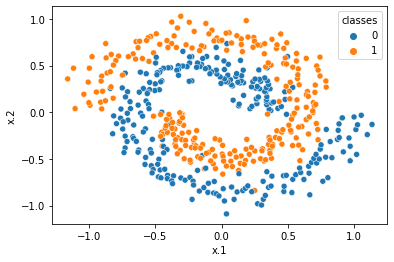

In [12]:
sns.scatterplot(x='x.1',y='x.2',hue='classes',data=df);

In [13]:
# split: 75 % for training, 25 % for test:
train_size = 0.75
train_indices = np.random.rand(len(df)) < train_size
train_df = df[train_indices]
test_df = df[~train_indices]

k_values = np.array([1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50,60,70,80,90,100])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df[['x.1','x.2']],df['classes'],test_size=1-train_size, random_state=42)

In [15]:
storage = pd.DataFrame(columns=["mmce_train", "mmce_test", "k"])
# storage=storage.astype({'k': 'int'})

In [16]:
for k in k_values:
    
    spiral_learner = KNeighborsClassifier(n_neighbors=k)
    spiral_learner.fit(X=X_train.values,y=y_train.values)
    
    spiral_pred_test=spiral_learner.predict(X_test.values)
    mmce_test = zero_one_loss(y_test.values,spiral_pred_test)
    
    spiral_pred_train=spiral_learner.predict(X_train.values)
    mmce_train = zero_one_loss(y_train.values,spiral_pred_train)
    
    storage=storage.append({'mmce_train':mmce_train,
                            'mmce_test':mmce_test,
                            'k':k}, ignore_index=True)

In [17]:
storage=storage.astype({'k': 'int'})

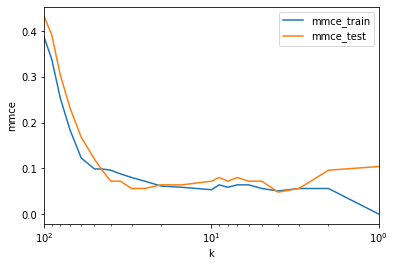

In [18]:
ax=sns.lineplot(x='k',y='mmce_train',data=storage);
sns.lineplot(x='k',y='mmce_test',data=storage,ax=ax);
plt.legend(['mmce_train','mmce_test']);
plt.ylabel('mmce')
ax.set_xscale('log')
ax.set_xlim(100,1);

The more complex our model (small k), the higher is the chance that the performance of the model on the
training data (in blue) is much better than the performance on new test data (in orange).

## How not to split: the good, the bad, the ugly
(How) Does the specific choice of splitting the data into train and test sets affect our estimation of the model
performance?

### The “good” split
We train on the first 30 data points and test on the next 20. Remember that iris is an ordered data set
with the first 50 observations being “setosa”, the next 50 “versicolor” and the last 50 “virginica”.

In [178]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
labels = iris.target_names

In [181]:
y,labels

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]),
 array(['setosa', 'versicolor', 'virginica'], dtype='<U10'))

In [183]:
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X[:30],y[:30])
pred=clf.predict(X[30:50])

In [201]:
print(f'mmce : {zero_one_loss(y[30:50],pred)}')

mmce : 0.0


In [202]:
print(f'confusion matrix : {confusion_matrix(y[30:50],pred)}')

confusion matrix : [[20]]


### The “bad” split

We train on the first 100 data points and test on the next 50.

In [204]:
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X[:100],y[:100])
pred=clf.predict(X[100:150])

In [205]:
print(f'mmce : {zero_one_loss(y[100:150],pred)}')

mmce : 1.0


Although we trained the learner, we get a test set MMCE of 1. The problem is that we never showed the
learner training data with the “virginica” label, so the training data does not represent the actual population
we want to classify. Try to formalize this in terms of the theory for supervised learners we have defined so far
– which assumption about the (training and test) data is not fulfilled here?
In statistics, we would call this a particularly severe example of selection bias.

### The "ugly" split

In [218]:
idx=np.arange(150)
np.random.shuffle(idx)
idx

array([128,  81,  95,  82,  98, 141,  90,  12, 118, 137,  43,  19,  85,
       115,  62,  93,   1,  38,  87, 106,  91, 101, 139, 131, 100,  94,
         2, 124,  77, 116,   7, 102, 146,  72,  18, 140,   3,  68,  97,
       119,  96, 103,  33,  22,  36,  69,  39,  45,   8, 148,  71,  48,
       149,  60,  14,  50,  24,  79,  49, 135, 122,  70,  75,  88,   6,
       120,  63,  16,  29,  35, 113,   0, 134,  55,  21,  26, 117, 144,
       127,   9,  66, 110, 132,  53,  76,  17, 142,  59, 123, 126, 121,
        44,  58, 143,  83,  37, 145,  51,  84, 138,  80,  27,  86,  10,
        54,  41, 125,  52,  57, 133,  30,  42,  56,  13, 111,  34,  28,
        99, 147,  46,  89, 112, 105,  92,  74,  31,   4,  23, 130,  65,
         5,  20,  64,  25, 107, 109, 108, 136,  11, 104,  67,  15,  61,
        73,  78, 129,  47,  40,  32, 114])

In [219]:
X=X[idx]
y=y[idx]
y

array([2, 1, 1, 1, 1, 2, 1, 0, 2, 2, 0, 0, 1, 2, 1, 1, 0, 0, 1, 2, 1, 2,
       2, 2, 2, 1, 0, 2, 1, 2, 0, 2, 2, 1, 0, 2, 0, 1, 1, 2, 1, 2, 0, 0,
       0, 1, 0, 0, 0, 2, 1, 0, 2, 1, 0, 1, 0, 1, 0, 2, 2, 1, 1, 1, 0, 2,
       1, 0, 0, 0, 2, 0, 2, 1, 0, 0, 2, 2, 2, 0, 1, 2, 2, 1, 1, 0, 2, 1,
       2, 2, 2, 0, 1, 2, 1, 0, 2, 1, 1, 2, 1, 0, 1, 0, 1, 0, 2, 1, 1, 2,
       0, 0, 1, 0, 2, 0, 0, 1, 2, 0, 1, 2, 2, 1, 1, 0, 0, 0, 2, 1, 0, 0,
       1, 0, 2, 2, 2, 2, 0, 2, 1, 0, 1, 1, 1, 2, 0, 0, 0, 2])

In [220]:
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X[:100],y[:100])
pred=clf.predict(X[100:150])

In [221]:
print(f'mmce : {zero_one_loss(y[100:150],pred)}')

mmce : 0.020000000000000018


In [224]:
print(f'confusion matrix \n {confusion_matrix(y[100:150],pred)}')

confusion matrix 
 [[20  0  0]
 [ 0 16  0]
 [ 0  1 13]]
